In [1]:
import contractions
import emoji
import time
import string 
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sb
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JoeTe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\JoeTe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JoeTe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JoeTe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\JoeTe\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Gensim (Word2Vec, Doc2Vec)
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec

# SKlearn
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay, accuracy_score, classification_report, silhouette_score, calinski_harabasz_score, accuracy_score
from sklearn.datasets import load_files
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD 
from sklearn.cluster import KMeans
#from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM,Dense,Dropout,Embedding,CuDNNLSTM,Bidirectional
from keras.layers import Embedding
from keras.models import Model, Sequential
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import keras

In [3]:
# Remove emojis 
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF" 
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def remove_stopwords(reviews):
    STOPWORDS = stopwords.words('english')
    STOPWORDS.remove('not')
    STOPWORDS.remove('is')
    STOPWORDS.remove('but')
    if STOPWORDS is None:
        STOPWORDS = set(stopwords.words('english'))
    return ' '.join([word for word in reviews.split() if word not in STOPWORDS])

def remove_extra_whitespace(reviews):
    return " ".join(reviews.split())

def get_wordnet_pos(text):
    # Map POS tag to first character lemmatize() accepts
    tags = nltk.pos_tag(text)
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    tags = [tag_dict.get(tag[1][0],  wordnet.NOUN) for tag in tags]
    return tags

def lemmaSentence(reviews):
    lemmatizer = WordNetLemmatizer()
    lemma_text = ''
    tok_text = word_tokenize(reviews)
    tags = get_wordnet_pos(tok_text)
    for i in range(len(tok_text)):
        lemma_text = lemma_text + ' ' + lemmatizer.lemmatize(tok_text[i], tags[i])
    return lemma_text[1:]

def lower_case(review):
    
    return review.lower()

# change contraction words such sa I'm = I am, shouldn't = should not
def change_contractions(review):
    
    expanded_words = [contractions.fix(word) for word in review.split()]

    expanded_review = ' '.join(expanded_words)
    return expanded_review

# Remove Punctuations
def remove_punctuations(review):
    
    new_review = review.translate(str.maketrans('', '', string.punctuation))
    return new_review

# Remove numbers
def remove_numbers(review):
    
    mapping = str.maketrans('', '', string.digits)
    new_review = review.translate(mapping)
    
    return new_review

In [4]:

def clean_text(data):

    data['concat_review'] = data['concat_review'].apply(lower_case)
    data['concat_review'] = data['concat_review'].apply(change_contractions)
    data['concat_review'] = data['concat_review'].apply(remove_emojis)
    data['concat_review'] = data['concat_review'].apply(remove_punctuations)
    data['concat_review'] = data['concat_review'].apply(remove_numbers)
    data['concat_review'] = data['concat_review'].apply(remove_stopwords)
    data['concat_review'] = data['concat_review'].apply(remove_extra_whitespace)
    data['concat_review'] = data['concat_review'].apply(lemmaSentence)
    
    return data

In [5]:
test_df_bryson = pd.read_csv('train_test_dataset/test_df_Bryson.csv')
test_df_kelvin = pd.read_csv('train_test_dataset/test_df_Kelvin.csv')
test_df_Gx =  pd.read_csv('train_test_dataset/test_df_Gx.csv')
df_list = [test_df_bryson, test_df_kelvin, test_df_Gx]
test_df = pd.concat(df_list,ignore_index=True)


In [6]:
test_df

,Unnamed: 0.1,Unnamed: 0,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,Annotator_1,Annotator_2,Unnamed: 0.2
0,0,24031,1982137452,1,The content is all messed up,NaN,I started this book this week for my book club...,True,children,Language.ENGLISH,-1,-1,NaN
1,1,22332,125030170X,1,Duplicate copy.Damaged book.,NaN,Pages missing.,True,children,Language.ENGLISH,-1,-1,NaN
2,2,23579,63215381,1,Awful,NaN,I gave up after 38% of my Kindle. Yes we were ...,True,children,Language.ENGLISH,-1,-1,NaN
3,3,20346,60935464,1,Syrupy Overload,3,The book is an example of leading the witness.,True,children,Language.ENGLISH,-1,-1,NaN
4,4,22874,1501161938,1,Couldn‚Äôt read it; type too small!,1,"Beware, the type is TINY, I mean TINY. I am 60...",True,children,Language.ENGLISH,-1,-1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2325,773,5161,399226907,5,Perfect Little Board Book,NaN,"I purchased the board book version, which is t...",True,children,Language.ENGLISH,1,1,773.0
2326,774,10559,1542046599,5,Twists and Turns Abound,NaN,"A great suspenseful, ""Who Done It"". I couldn'...",True,mystery,Language.ENGLISH,1,1,774.0
2327,775,7199,B01M0JHBEG,5,we love lift the flaps!,NaN,"This book is a lot of fun for Halloween, with ...",True,children,Language.ENGLISH,1,1,775.0
2328,776,8504,141501596,5,Books ~ the Knowledge Source,NaN,"""June & Jack must read three books before they...",True,children,Language.ENGLISH,1,1,776.0


In [7]:
test_df.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0', 'Unnamed: 0.2'], inplace = True)
test_df

,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,Annotator_1,Annotator_2
0,1982137452,1,The content is all messed up,NaN,I started this book this week for my book club...,True,children,Language.ENGLISH,-1,-1
1,125030170X,1,Duplicate copy.Damaged book.,NaN,Pages missing.,True,children,Language.ENGLISH,-1,-1
2,63215381,1,Awful,NaN,I gave up after 38% of my Kindle. Yes we were ...,True,children,Language.ENGLISH,-1,-1
3,60935464,1,Syrupy Overload,3,The book is an example of leading the witness.,True,children,Language.ENGLISH,-1,-1
4,1501161938,1,Couldn‚Äôt read it; type too small!,1,"Beware, the type is TINY, I mean TINY. I am 60...",True,children,Language.ENGLISH,-1,-1
...,...,...,...,...,...,...,...,...,...,...
2325,399226907,5,Perfect Little Board Book,NaN,"I purchased the board book version, which is t...",True,children,Language.ENGLISH,1,1
2326,1542046599,5,Twists and Turns Abound,NaN,"A great suspenseful, ""Who Done It"". I couldn'...",True,mystery,Language.ENGLISH,1,1
2327,B01M0JHBEG,5,we love lift the flaps!,NaN,"This book is a lot of fun for Halloween, with ...",True,children,Language.ENGLISH,1,1
2328,141501596,5,Books ~ the Knowledge Source,NaN,"""June & Jack must read three books before they...",True,children,Language.ENGLISH,1,1


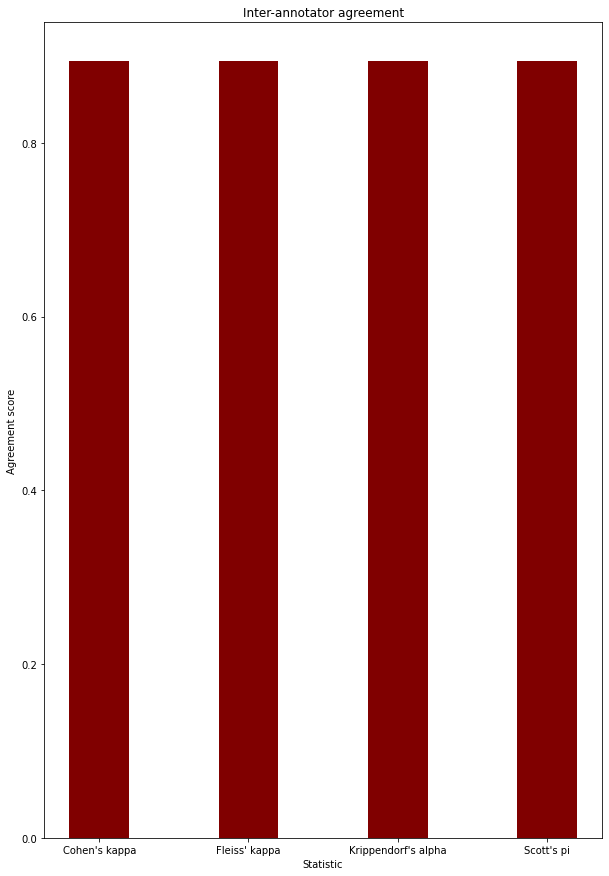

In [8]:
## Inter-annotator agreement

from nltk import agreement
import matplotlib.pyplot as plt

annotator_1 = test_df["Annotator_1"].to_numpy()
annotator_2 = test_df["Annotator_2"].to_numpy()

taskdata=[[0,str(i),str(annotator_1[i])] for i in range(0,len(annotator_1))]+[[1,str(i),str(annotator_2[i])] for i in range(0,len(annotator_2))]
ratingtask = agreement.AnnotationTask(data=taskdata)

cohen_kappa = ratingtask.kappa()
fleiss_kappa = ratingtask.multi_kappa()
krippendorf_alpha = ratingtask.alpha()
scotts_pi = ratingtask.pi()

scores = {"Cohen's kappa": cohen_kappa, "Fleiss' kappa": fleiss_kappa, "Krippendorf's alpha": krippendorf_alpha, "Scott's pi" : scotts_pi}

statistic = list(scores.keys())
values = list(scores.values())

fig = plt.figure(figsize = (10, 15))
plt.bar(statistic, values, color ='maroon',
        width = 0.4)
plt.xlabel("Statistic")
plt.ylabel("Agreement score")
plt.title("Inter-annotator agreement")
plt.show()

In [9]:
print(scores)

{"Cohen's kappa": 0.8939596693834795, "Fleiss' kappa": 0.8939596693834795, "Krippendorf's alpha": 0.8939792292501598, "Scott's pi": 0.8939564731285137}


In [10]:
# Initially during our self-annotation, we label Positive as 1, Neutral as 0 and Negative -1

# Now we look at counts of each label based on Annotator_1
test_df["Annotator_1"].value_counts()

 1    1579
-1     648
 0     103
Name: Annotator_1, dtype: int64

In [11]:
# Credits to Jacitha's notebook
# We are going to use polarity detection so we drop all neutral reviews and convert the polarity
# positive -> 1
# negative -> 0
test_df['polarity'] = test_df['Annotator_1']
test_df = test_df.loc[test_df.polarity != 0]
test_df.loc[test_df['polarity'] == -1, 'polarity'] = 0
print(len(test_df))
test_df.head()

2227


,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,Annotator_1,Annotator_2,polarity
0,1982137452,1,The content is all messed up,NaN,I started this book this week for my book club...,True,children,Language.ENGLISH,-1,-1,0
1,125030170X,1,Duplicate copy.Damaged book.,NaN,Pages missing.,True,children,Language.ENGLISH,-1,-1,0
2,63215381,1,Awful,NaN,I gave up after 38% of my Kindle. Yes we were ...,True,children,Language.ENGLISH,-1,-1,0
3,60935464,1,Syrupy Overload,3,The book is an example of leading the witness.,True,children,Language.ENGLISH,-1,-1,0
4,1501161938,1,Couldn‚Äôt read it; type too small!,1,"Beware, the type is TINY, I mean TINY. I am 60...",True,children,Language.ENGLISH,-1,-1,0


In [12]:
test_df['concat_review'] = test_df['reviewTitle'] + '. ' + test_df['reviewDescription']
test_df = clean_text(test_df)

C:\Users\JoeTe\AppData\Local\Temp/ipykernel_23272/4288870705.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['concat_review'] = test_df['reviewTitle'] + '. ' + test_df['reviewDescription']
C:\Users\JoeTe\AppData\Local\Temp/ipykernel_23272/505156730.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['concat_review'] = data['concat_review'].apply(lower_case)
C:\Users\JoeTe\AppData\Local\Temp/ipykernel_23272/505156730.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [13]:
test_df

,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,Annotator_1,Annotator_2,polarity,concat_review
0,1982137452,1,The content is all messed up,NaN,I started this book this week for my book club...,True,children,Language.ENGLISH,-1,-1,0,content be mess started book week book club ca...
1,125030170X,1,Duplicate copy.Damaged book.,NaN,Pages missing.,True,children,Language.ENGLISH,-1,-1,0,duplicate copydamaged book page miss
2,63215381,1,Awful,NaN,I gave up after 38% of my Kindle. Yes we were ...,True,children,Language.ENGLISH,-1,-1,0,awful give kindle yes tell someone die but not...
3,60935464,1,Syrupy Overload,3,The book is an example of leading the witness.,True,children,Language.ENGLISH,-1,-1,0,syrupy overload book be example lead witness
4,1501161938,1,Couldn‚Äôt read it; type too small!,1,"Beware, the type is TINY, I mean TINY. I am 60...",True,children,Language.ENGLISH,-1,-1,0,couldn‚äôt read type small beware type be tiny...
...,...,...,...,...,...,...,...,...,...,...,...,...
2325,399226907,5,Perfect Little Board Book,NaN,"I purchased the board book version, which is t...",True,children,Language.ENGLISH,1,1,1,perfect little board book purchase board book ...
2326,1542046599,5,Twists and Turns Abound,NaN,"A great suspenseful, ""Who Done It"". I couldn'...",True,mystery,Language.ENGLISH,1,1,1,twist turn abound great suspenseful do could n...
2327,B01M0JHBEG,5,we love lift the flaps!,NaN,"This book is a lot of fun for Halloween, with ...",True,children,Language.ENGLISH,1,1,1,love lift flap book be lot fun halloween innoc...
2328,141501596,5,Books ~ the Knowledge Source,NaN,"""June & Jack must read three books before they...",True,children,Language.ENGLISH,1,1,1,book knowledge source june jack must read thre...


In [14]:
train_data = pd.read_csv('subjective_reviews.csv')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13210 entries, 0 to 13209
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0.1       13210 non-null  int64  
 1   Unnamed: 0         13210 non-null  int64  
 2   productAsin        13210 non-null  object 
 3   ratingScore        13210 non-null  int64  
 4   reviewTitle        13210 non-null  object 
 5   reviewReaction     3577 non-null   object 
 6   reviewDescription  13210 non-null  object 
 7   isVerified         13210 non-null  bool   
 8   category           13210 non-null  object 
 9   languages          13210 non-null  object 
 10  concat_review      13210 non-null  object 
 11  polarity           13210 non-null  int64  
 12  cleaned_text       13210 non-null  object 
 13  tb_subjectivity    13210 non-null  float64
 14  tb_polarity        13210 non-null  float64
 15  pos_tags           13210 non-null  object 
 16  senti_score        132

In [15]:
# Pre-processing of datafame
clean_train_data_df = clean_text(train_data)
clean_train_data_df

,Unnamed: 0.1,Unnamed: 0,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,concat_review,polarity,cleaned_text,tb_subjectivity,tb_polarity,pos_tags,senti_score,swn_subjectivity
0,1,5701,670062510,5,A great book for young people. It has a great...,NaN,My favorite book when I was young. I read it ...,True,children,Language.ENGLISH,great book young people great story favorite b...,1,A great book for young people. It has a great...,0.539394,0.271633,"[('A', 'DT'), ('great', 'JJ'), ('book', 'NN'),...",1.125,1
1,3,5021,399226907,5,Add this book to your collection,NaN,Cute and educational book to teach counting an...,True,children,Language.ENGLISH,add book collection cute educational book teac...,1,Add this book to your collection. Cute and edu...,0.580000,0.355000,"[('Add', 'VB'), ('this', 'DT'), ('book', 'NN')...",1.000,1
2,4,21354,125030170X,2,Just okay.,NaN,This is one of those books you can read in a c...,False,children,Language.ENGLISH,okay be one book read couple day story okay,0,Just okay.. This is one of those books you can...,0.500000,0.500000,"[('Just', 'RB'), ('okay', 'RB'), ('..', 'VB'),...",0.500,1
3,5,23286,63215381,1,The paperback‚Äôs quality sucks,1,I hate this paperback. Terrible quality! The p...,True,children,Language.ENGLISH,paperback‚äôs quality suck hate paperback terr...,0,The paperback‚Äôs quality sucks. I hate this p...,0.697778,-0.490000,"[('The', 'DT'), ('paperback‚Äôs', 'NN'), ('qua...",-1.375,1
4,7,15810,1984806734,4,4.5 Fantastic Stars!!!,One person found this helpful,I‚Äôve seen people rate this book highly for m...,False,romance,Language.ENGLISH,fantastic star i‚äôve see people rate book hig...,1,4.5 Fantastic Stars!!!. I‚Äôve seen people rat...,0.588545,0.203599,"[('4.5', 'CD'), ('Fantastic', 'JJ'), ('Stars',...",10.375,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13205,20951,4658,385376715,5,Awesome book!,NaN,I love this book. I purchased it for a baby sh...,True,children,Language.ENGLISH,awesome book love book purchase baby shower gi...,1,Awesome book!. I love this book. I purchased i...,0.780000,0.582500,"[('Awesome', 'JJ'), ('book', 'NN'), ('!', '.')...",1.375,1
13206,20955,11788,1542046599,4,Surprising ending,NaN,"Well written, interesting switches to differen...",True,mystery,Language.ENGLISH,surprise end well write interesting switch dif...,1,"Surprising ending. Well written, interesting s...",0.510714,0.404762,"[('Surprising', 'VBG'), ('ending', 'VBG'), ('....",0.625,1
13207,20958,5670,670062510,4,My 7th graders not only love this book but the...,NaN,My 7th graders not only love this book but the...,True,children,Language.ENGLISH,th grader not love book but hard bound be must...,1,My 7th graders not only love this book but the...,0.680247,0.067901,"[('My', 'PRP$'), ('7th', 'CD'), ('graders', 'N...",-3.125,1
13208,20959,891,B01IW9TM5O,5,One of my favorite books ever - read almost al...,One person found this helpful,One of my favorite books ever - read almost al...,True,humor_entertainment,Language.ENGLISH,one favorite book ever read almost one favorit...,1,One of my favorite books ever - read almost al...,0.580134,0.371544,"[('One', 'CD'), ('of', 'IN'), ('my', 'PRP$'), ...",2.375,1


In [16]:
# Check if the dataset is balanced
clean_train_data_df["polarity"].value_counts()

1    9593
0    3617
Name: polarity, dtype: int64

## Balancing train dataset

In [17]:
# Drop the excess positive reviews randomly
differences = clean_train_data_df["polarity"].value_counts()[1]-clean_train_data_df["polarity"].value_counts()[0]
train_balanced_df = clean_train_data_df.drop(clean_train_data_df[clean_train_data_df["polarity"] == 1].sample(differences,random_state=42).index)
train_balanced_df

,Unnamed: 0.1,Unnamed: 0,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,concat_review,polarity,cleaned_text,tb_subjectivity,tb_polarity,pos_tags,senti_score,swn_subjectivity
1,3,5021,399226907,5,Add this book to your collection,NaN,Cute and educational book to teach counting an...,True,children,Language.ENGLISH,add book collection cute educational book teac...,1,Add this book to your collection. Cute and edu...,0.580000,0.355000,"[('Add', 'VB'), ('this', 'DT'), ('book', 'NN')...",1.000,1
2,4,21354,125030170X,2,Just okay.,NaN,This is one of those books you can read in a c...,False,children,Language.ENGLISH,okay be one book read couple day story okay,0,Just okay.. This is one of those books you can...,0.500000,0.500000,"[('Just', 'RB'), ('okay', 'RB'), ('..', 'VB'),...",0.500,1
3,5,23286,63215381,1,The paperback‚Äôs quality sucks,1,I hate this paperback. Terrible quality! The p...,True,children,Language.ENGLISH,paperback‚äôs quality suck hate paperback terr...,0,The paperback‚Äôs quality sucks. I hate this p...,0.697778,-0.490000,"[('The', 'DT'), ('paperback‚Äôs', 'NN'), ('qua...",-1.375,1
6,12,4101,B096MWJLNW,4,Good job will,NaN,I loved his honesty. It eas an informative read.,True,humor_entertainment,Language.ENGLISH,good job love honesty ea informative read,1,Good job will. I loved his honesty. It eas an...,0.700000,0.700000,"[('Good', 'JJ'), ('job', 'NN'), ('will', 'MD')...",1.250,1
7,13,1094,B01IW9TM5O,5,"Nice, easy read",NaN,"Nice story, good ending, good to tead",True,humor_entertainment,Language.ENGLISH,nice easy read nice story good end good tead,1,"Nice, easy read. Nice story, good ending, good...",0.806667,0.606667,"[('Nice', 'NNP'), (',', ','), ('easy', 'JJ'), ...",2.125,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13196,20942,5589,670062510,5,Good reading,NaN,Good value,True,children,Language.ENGLISH,good reading good value,1,Good reading. Good value,0.600000,0.700000,"[('Good', 'JJ'), ('reading', 'NN'), ('.', '.')...",1.500,1
13197,20943,2542,1982185821,5,"Witty, genuine, and overall well-written",NaN,I loved the book. It breaks my heart to read s...,True,humor_entertainment,Language.ENGLISH,witty genuine overall wellwritten love book br...,1,"Witty, genuine, and overall well-written. I lo...",0.640909,0.238636,"[('Witty', 'NNP'), (',', ','), ('genuine', 'NN...",0.875,1
13203,20949,14990,B07GX3BR7P,5,It's a Great Read,NaN,I was curious from beginning to the end. It h...,True,mystery,Language.ENGLISH,be great read curious begin end good character...,1,It's a Great Read. I was curious from beginnin...,0.783333,0.466667,"[('It', 'PRP'), (""'s"", 'VBZ'), ('a', 'DT'), ('...",0.750,1
13204,20950,22935,1501161938,1,"So many great reviews, I just wanted it to end",19,I feel hoodwinked on this book. So many great ...,True,children,Language.ENGLISH,many great review want end feel hoodwink book ...,0,"So many great reviews, I just wanted it to end...",0.700000,0.420000,"[('So', 'RB'), ('many', 'JJ'), ('great', 'JJ')...",-0.375,1


Text(0, 0.5, 'Frequency')

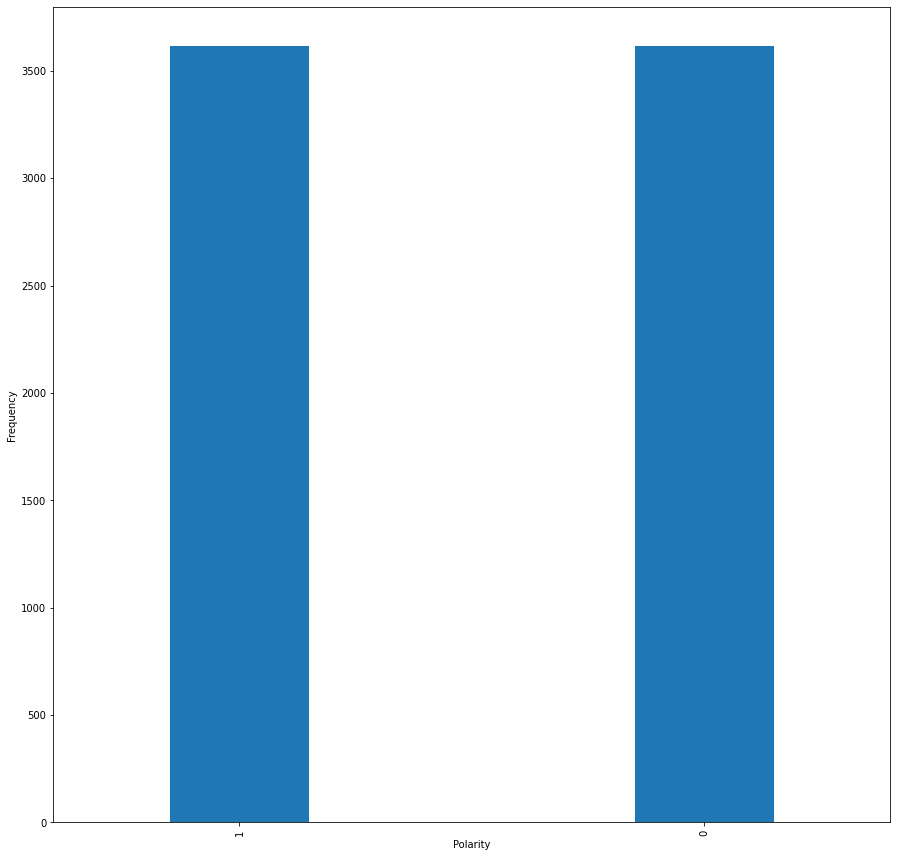

In [18]:
train_balanced_df['polarity'].value_counts(sort=False).plot.bar(figsize=(15,15), width = 0.3)
plt.xlabel('Polarity')
plt.ylabel('Frequency')

#### Visualization

In [19]:
def get_wordcloud(text, color='viridis'):
  # Create a WordCloud object
  
  wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', colormap=color)
  # Generate a word cloud
  return wordcloud.generate(text)

(-0.5, 399.5, 199.5, -0.5)

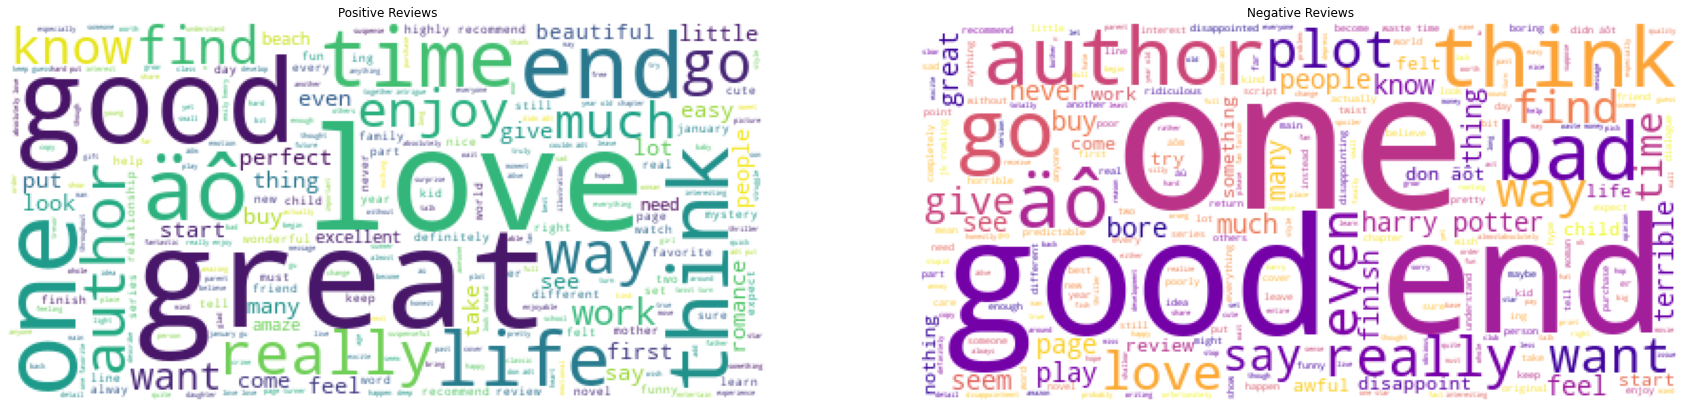

In [20]:
fig, axes =plt.subplots(1,2, figsize=(30,30))

# Wordcloud for positive reviews
pos_reviews = ' '.join(train_balanced_df['concat_review'][train_balanced_df['polarity']==1].values)
words = ['well', 'make', 'book', 'use', 'read', 'write','story', 'character']
for word in words:
  pos_reviews = pos_reviews.replace(word, '')

axes[0].set_title("Positive Reviews")
axes[0].imshow(get_wordcloud(pos_reviews))
axes[0].axis('off')

# Wordcloud for negative reviews
neg_reviews = ' '.join(train_balanced_df['concat_review'][train_balanced_df['polarity']==0].values)

# Common words
words = ['well', 'make', 'book', 'use', 'read', 'write','story','character']
for word in words:
  neg_reviews = neg_reviews.replace(word, '')

axes[1].set_title("Negative Reviews")
axes[1].imshow(get_wordcloud(neg_reviews,'plasma'))
axes[1].axis('off')



## Modelling

In [21]:
X = train_balanced_df["concat_review"].values
Y = train_balanced_df['polarity'].values

unseen_X_test = test_df['concat_review'].values
unseen_Y_test = test_df['polarity'].values

In [22]:
# Train and test split 
# 80 train 20 test split
X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


#### Different methods of vectorizing text

**Tf-Idf**

In [23]:
# Tf-Idf representation
tfidf_vect = TfidfVectorizer(min_df=5, max_features=10000, ngram_range=(1,2), lowercase=False, tokenizer=word_tokenize)

X_train_tfidf = tfidf_vect.fit_transform(X_train)
x_test_tfidf = tfidf_vect.transform(x_test)
unseen_X_test_tfidf = tfidf_vect.transform(unseen_X_test)

**Word2Vec - Averaged vector**




In [24]:
# Tokenization
X_train_tok = [word_tokenize(sentence) for sentence in X_train]
x_test_tok = [word_tokenize(sentence) for sentence in x_test]

unseen_X_test_tok = [word_tokenize(sentence) for sentence in unseen_X_test]

In [25]:
# Word2Vec model
model_word2vec = Word2Vec(min_count=2,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20)



In [26]:
# Building vocabulary
model_word2vec.build_vocab(X_train_tok)

In [27]:
# Training model
model_word2vec.train(X_train_tok, total_examples=model_word2vec.corpus_count, epochs=30, report_delay=1)
model_word2vec.save("model/word2vec.model")

In [28]:
model_word2vec = gensim.models.word2vec.Word2Vec.load("model/word2vec.model")

In [29]:
# Compute mean vector given the word2vec vector for every word in a document
def get_mean_vector(model, words):
    # remove out-of-vocabulary words
    words = [word for word in words if word in model.wv.key_to_index]
    if len(words) >= 1:
        return model.wv.get_mean_vector(words)
    else:
        return np.zeros(300)

In [30]:
# Get the mean vector
X_train_Word2Vec = [get_mean_vector(model_word2vec, review) for review in X_train_tok]
x_test_Word2Vec = [get_mean_vector(model_word2vec, review) for review in x_test_tok]

unseen_X_test_Word2Vec = [get_mean_vector(model_word2vec, review) for review in unseen_X_test_tok]


In [31]:
# Scaling values between 0 and 1


scaler_Word2Vec = MinMaxScaler(feature_range=(0,1))
X_train_Word2Vec = scaler_Word2Vec.fit_transform(X_train_Word2Vec)
x_test_Word2Vec = scaler_Word2Vec.transform(x_test_Word2Vec)

unseen_X_test_Word2Vec = scaler_Word2Vec.transform(unseen_X_test_Word2Vec)


## Doc2Vec

In [32]:
# Tag all the documents
tagged_data = [TaggedDocument(doc, tags=[str(i)]) for i, doc in enumerate(X_train_tok)]

In [33]:
# Building of the Doc2Vec model
model_doc2vec = gensim.models.doc2vec.Doc2Vec(vector_size=100, window=5, min_count=2, epochs=10)
model_doc2vec.build_vocab(tagged_data)
model_doc2vec.train(tagged_data, total_examples=model_doc2vec.corpus_count, epochs=model_doc2vec.epochs)


In [34]:
model_doc2vec.save("model/doc2vec.model")


In [35]:
model_doc2vec = gensim.models.doc2vec.Doc2Vec.load("model/doc2vec.model")

In [36]:
# Get the vectors for every document
X_train_Doc2Vec = model_doc2vec.dv.vectors
x_test_Doc2Vec = [model_doc2vec.infer_vector(doc) for doc in x_test_tok]
unseen_X_test_Doc2Vec = [model_doc2vec.infer_vector(doc) for doc in unseen_X_test_tok]


In [37]:
# Scaling values between 0 and 1
scaler_Doc2Vec = MinMaxScaler(feature_range=(0,1))
X_train_Doc2Vec = scaler_Doc2Vec.fit_transform(X_train_Doc2Vec)
x_test_Doc2Vec = scaler_Doc2Vec.transform(x_test_Doc2Vec)
unseen_X_test_Doc2Vec = scaler_Doc2Vec.transform(unseen_X_test_Doc2Vec)


In [38]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    
    cm = confusion_matrix(y_true, y_pred)
    conf_matrix=pd.DataFrame(data=cm,columns=['Predicted: 0','Predicted: 1'],
                                         index=['Actual: 0','Actual: 1'])
                                                        
    plt.figure(figsize = (10,5))
    sb.set(font_scale=1.2)
    sb.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
    plt.title(f"Confusion Matrix for Sentiment Analysis using {model_name}")
    plt.yticks(rotation=360)
    plt.show()

    print(f"Confusion Matrix for Sentiment Analysis using {model_name}:",accuracy_score(y_true, y_pred))
    print("-"*100)
    print(f"Classification Report for Sentiment Analysis using {model_name}:\n\n",classification_report(y_true, y_pred))
    print("-"*100)

In [39]:
## Auto classification of results

def get_pred_df(test_df, predictions):

    df = test_df.copy()
    df["Predictions"] = predictions
    return df


## Traditional Machine Learning Models

Naive Bayes

In [40]:
def naive_bayes_model(x_train, y_train):
    # Naive bayes
    naive_bayes_mod = MultinomialNB()
    naive_bayes_mod.fit(x_train, y_train)
    

    return naive_bayes_mod


Linear SVC

In [41]:
# Support vector machine
def Linear_SVC_model(X_train, Y_train):
    Linear_SVC_mod = LinearSVC(max_iter=5000)
    Linear_SVC_mod.fit(X_train, Y_train)

    return Linear_SVC_mod


Logistic Regression

In [42]:
# Logistic regression
def LogisticRegression_model(X_train, Y_train):
    Logistic_Regression_mod = LogisticRegression(max_iter=3000)
    Logistic_Regression_mod.fit(X_train, Y_train)

    return Logistic_Regression_mod

## Tf-Idf

In [43]:
naive_bayes_tfidf = naive_bayes_model(X_train_tfidf, Y_train)
Linear_SVC_tfidf = Linear_SVC_model(X_train_tfidf, Y_train)
Logistic_Regression_tfidf = LogisticRegression_model(X_train_tfidf, Y_train)



nb_tfidf_file = "trained_models/Naive_Bayes_TFIDF_model.pkl"
linear_svc_tfidf_file = "trained_models/Linear_SVC_TFIDF_model.pkl"
lr_tfidf_file = "trained_models/Logistic_Regression_TFIDF_model.pkl"

joblib.dump(naive_bayes_tfidf, nb_tfidf_file)
joblib.dump(Linear_SVC_tfidf, linear_svc_tfidf_file)
joblib.dump(Logistic_Regression_tfidf, lr_tfidf_file)

['trained_models/Logistic_Regression_TFIDF_model.pkl']

In [44]:
naive_bayes_tfidf_prediction = naive_bayes_tfidf.predict(x_test_tfidf)
Linear_SVC_tfidf_prediction = Linear_SVC_tfidf.predict(x_test_tfidf)
Logistic_Regression_tfidf_prediction = Logistic_Regression_tfidf.predict(x_test_tfidf)

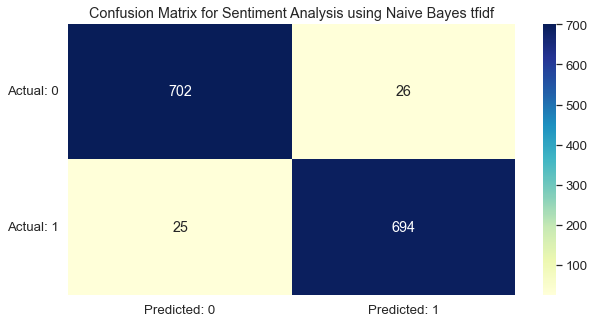

Confusion Matrix for Sentiment Analysis using Naive Bayes tfidf: 0.9647546648237734
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Naive Bayes tfidf:

               precision    recall  f1-score   support

           0       0.97      0.96      0.96       728
           1       0.96      0.97      0.96       719

    accuracy                           0.96      1447
   macro avg       0.96      0.96      0.96      1447
weighted avg       0.96      0.96      0.96      1447

----------------------------------------------------------------------------------------------------


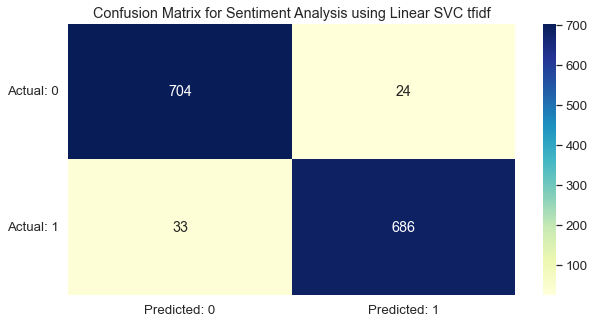

Confusion Matrix for Sentiment Analysis using Linear SVC tfidf: 0.9606081548030407
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Linear SVC tfidf:

               precision    recall  f1-score   support

           0       0.96      0.97      0.96       728
           1       0.97      0.95      0.96       719

    accuracy                           0.96      1447
   macro avg       0.96      0.96      0.96      1447
weighted avg       0.96      0.96      0.96      1447

----------------------------------------------------------------------------------------------------


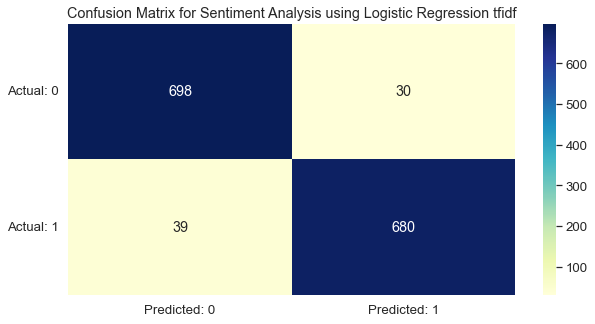

Confusion Matrix for Sentiment Analysis using Logistic Regression tfidf: 0.9523151347615757
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Logistic Regression tfidf:

               precision    recall  f1-score   support

           0       0.95      0.96      0.95       728
           1       0.96      0.95      0.95       719

    accuracy                           0.95      1447
   macro avg       0.95      0.95      0.95      1447
weighted avg       0.95      0.95      0.95      1447

----------------------------------------------------------------------------------------------------


In [45]:
plot_confusion_matrix(y_test, naive_bayes_tfidf_prediction, "Naive Bayes tfidf")
plot_confusion_matrix(y_test,  Linear_SVC_tfidf_prediction, "Linear SVC tfidf")
plot_confusion_matrix(y_test,  Logistic_Regression_tfidf_prediction, "Logistic Regression tfidf")

In [46]:
length = unseen_X_test_tfidf.shape[0]
print(length)

start_time = time.time()
unseen_naive_bayes_tfidf_prediction = naive_bayes_tfidf.predict(unseen_X_test_tfidf)
time_taken = time.time()-start_time
classified_per_sec = length/time_taken
print("Predictions for Naive Bayes TF-IDF took ", time_taken, " seconds")
print("Number of reviews classified for Naive Bayes TF-IDF per second: ", classified_per_sec)
nb_tfidf_time_list = ["Naive Bayes TFIF", time_taken, classified_per_sec]

start_time=time.time()
unseen_Linear_SVC_tfidf_prediction = Linear_SVC_tfidf.predict(unseen_X_test_tfidf)
time_taken = time.time()-start_time
classified_per_sec = length/time_taken
print("Predictions for Linear_SVC TF-IDF took ", time_taken, " seconds")
print("Number of reviews classified for Linear_SVC TF-IDF per second: ", classified_per_sec)
svc_tfidf_time_list = ["Linear_SVC TF-IDF",time_taken, classified_per_sec]

start_time=time.time()
unseen_Logistic_Regression_tfidf_prediction = Logistic_Regression_tfidf.predict(unseen_X_test_tfidf)
time_taken = time.time()-start_time
classified_per_sec = length/time_taken
print("Predictions for Logistic Regression TF-IDF took ", time_taken, " seconds")
print("Number of reviews classified for Logistic Regression TF-IDF per second: ", classified_per_sec)
lr_tfidf_time_list = ["Logistic Regression TF-IDF",time_taken, classified_per_sec]


2227
Predictions for Naive Bayes TF-IDF took  0.0019996166229248047  seconds
Number of reviews classified for Naive Bayes TF-IDF per second:  1113713.486109455
Predictions for Linear_SVC TF-IDF took  0.0010068416595458984  seconds
Number of reviews classified for Linear_SVC TF-IDF per second:  2211867.157944589
Predictions for Logistic Regression TF-IDF took  0.0011851787567138672  seconds
Number of reviews classified for Logistic Regression TF-IDF per second:  1879041.4419633877


## Saving Results

In [47]:
path = "saved_results/"
nb_tfidf_test_df_predicted = get_pred_df(test_df, unseen_naive_bayes_tfidf_prediction)
nb_tfidf_test_df_predicted.to_csv(path+'Naive_Bayes_TFIDF_results.csv')

svc_tfidf_test_df_predicted = get_pred_df(test_df, unseen_Linear_SVC_tfidf_prediction)
svc_tfidf_test_df_predicted.to_csv(path+'SVM_TFIDF_results.csv')

lr_tfidf_test_df_predicted = get_pred_df(test_df, unseen_Logistic_Regression_tfidf_prediction)
lr_tfidf_test_df_predicted.to_csv(path+'Logistic_Regression_TFIDF_results.csv')

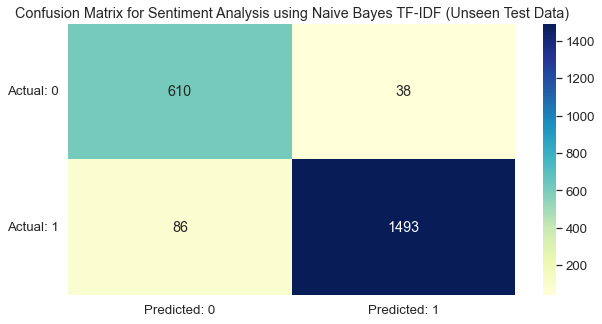

Confusion Matrix for Sentiment Analysis using Naive Bayes TF-IDF (Unseen Test Data): 0.9443197126178716
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Naive Bayes TF-IDF (Unseen Test Data):

               precision    recall  f1-score   support

           0       0.88      0.94      0.91       648
           1       0.98      0.95      0.96      1579

    accuracy                           0.94      2227
   macro avg       0.93      0.94      0.93      2227
weighted avg       0.95      0.94      0.94      2227

----------------------------------------------------------------------------------------------------


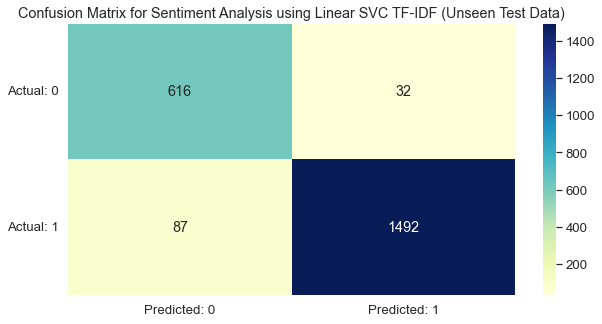

Confusion Matrix for Sentiment Analysis using Linear SVC TF-IDF (Unseen Test Data): 0.9465648854961832
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Linear SVC TF-IDF (Unseen Test Data):

               precision    recall  f1-score   support

           0       0.88      0.95      0.91       648
           1       0.98      0.94      0.96      1579

    accuracy                           0.95      2227
   macro avg       0.93      0.95      0.94      2227
weighted avg       0.95      0.95      0.95      2227

----------------------------------------------------------------------------------------------------


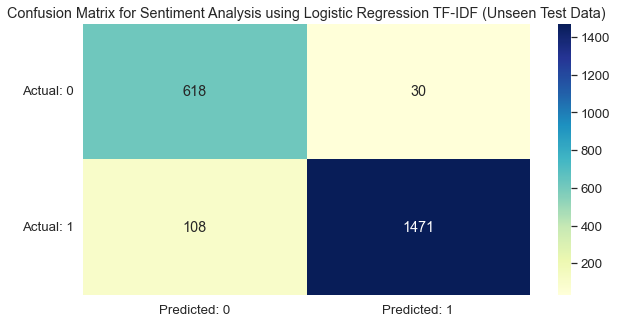

Confusion Matrix for Sentiment Analysis using Logistic Regression TF-IDF (Unseen Test Data): 0.938033228558599
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Logistic Regression TF-IDF (Unseen Test Data):

               precision    recall  f1-score   support

           0       0.85      0.95      0.90       648
           1       0.98      0.93      0.96      1579

    accuracy                           0.94      2227
   macro avg       0.92      0.94      0.93      2227
weighted avg       0.94      0.94      0.94      2227

----------------------------------------------------------------------------------------------------


In [48]:
plot_confusion_matrix(unseen_Y_test, unseen_naive_bayes_tfidf_prediction, "Naive Bayes TF-IDF (Unseen Test Data)")
plot_confusion_matrix(unseen_Y_test,  unseen_Linear_SVC_tfidf_prediction, "Linear SVC TF-IDF (Unseen Test Data)")
plot_confusion_matrix(unseen_Y_test,  unseen_Logistic_Regression_tfidf_prediction, "Logistic Regression TF-IDF (Unseen Test Data)")

In [49]:
from sklearn import metrics

print("MultinomialNB Accuracy for TF-IDF:",metrics.accuracy_score(y_test, naive_bayes_tfidf_prediction))
print("MultinomialNB Accuracy for unseen TF-IDF:",metrics.accuracy_score(unseen_Y_test,  unseen_naive_bayes_tfidf_prediction))
naive_bayes_tfidf_score = metrics.accuracy_score(y_test, naive_bayes_tfidf_prediction)
unseen_naive_bayes_tfidf_score = metrics.accuracy_score(unseen_Y_test, unseen_naive_bayes_tfidf_prediction)

print("Linear SVC Accuracy for TF-IDF:",metrics.accuracy_score(y_test, Linear_SVC_tfidf_prediction))
print("Linear SVC Accuracy for unseen TF-IDF:",metrics.accuracy_score(unseen_Y_test, unseen_Linear_SVC_tfidf_prediction))
Linear_SVC_tfidf_score = metrics.accuracy_score(y_test, Linear_SVC_tfidf_prediction)
unseen_Linear_SVC_tfidf_score = metrics.accuracy_score(unseen_Y_test, unseen_Linear_SVC_tfidf_prediction)

print("Logistic Regression Accuracy for TF-IDF:",metrics.accuracy_score(y_test, Logistic_Regression_tfidf_prediction))
print("Logistic Regression Accuracy for unseen test TF-IDF:",metrics.accuracy_score(unseen_Y_test, unseen_Logistic_Regression_tfidf_prediction))
Logistic_Regression_tfidf_score = metrics.accuracy_score(y_test, Logistic_Regression_tfidf_prediction)
unseen_Logistic_Regression_tfidf_score = metrics.accuracy_score(unseen_Y_test, unseen_Logistic_Regression_tfidf_prediction)

tfidf_score_list = [naive_bayes_tfidf_score, Linear_SVC_tfidf_score, Logistic_Regression_tfidf]
tfidf_unseen_score_lsit = [unseen_naive_bayes_tfidf_score, unseen_Linear_SVC_tfidf_score, unseen_Linear_SVC_tfidf_score]



MultinomialNB Accuracy for TF-IDF: 0.9647546648237734
MultinomialNB Accuracy for unseen TF-IDF: 0.9443197126178716
Linear SVC Accuracy for TF-IDF: 0.9606081548030407
Linear SVC Accuracy for unseen TF-IDF: 0.9465648854961832
Logistic Regression Accuracy for TF-IDF: 0.9523151347615757
Logistic Regression Accuracy for unseen test TF-IDF: 0.938033228558599


## Word2Vec - Averaged vector

In [50]:
naive_bayes_Word2Vec = naive_bayes_model(X_train_Word2Vec, Y_train)
# Support vector machine
Linear_SVC_Word2Vec = Linear_SVC_model(X_train_Word2Vec, Y_train)
# Logistic regression
Logistic_Regression_Word2Vec = LogisticRegression_model(X_train_Word2Vec, Y_train)



nb_w2v_file = "trained_models/Naive_Bayes_W2V_model.pkl"
linear_svc_w2v_file = "trained_models/Linear_SVC_W2V_model.pkl"
lr_w2v_file = "trained_models/Logistic_Regression_W2V_model.pkl"

joblib.dump(naive_bayes_Word2Vec, nb_w2v_file)
joblib.dump(Linear_SVC_Word2Vec, linear_svc_w2v_file)
joblib.dump(Logistic_Regression_Word2Vec, lr_w2v_file)


['trained_models/Logistic_Regression_W2V_model.pkl']

In [51]:
naive_bayes_Word2Vec_prediction = naive_bayes_Word2Vec.predict(x_test_Word2Vec)
Linear_SVC_Word2Vec_prediction = Linear_SVC_Word2Vec.predict(x_test_Word2Vec)
Logistic_Regression_Word2Vec_prediction = Logistic_Regression_Word2Vec.predict(x_test_Word2Vec)

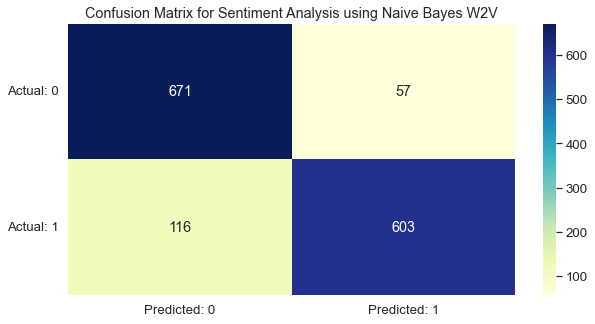

Confusion Matrix for Sentiment Analysis using Naive Bayes W2V: 0.8804422944022114
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Naive Bayes W2V:

               precision    recall  f1-score   support

           0       0.85      0.92      0.89       728
           1       0.91      0.84      0.87       719

    accuracy                           0.88      1447
   macro avg       0.88      0.88      0.88      1447
weighted avg       0.88      0.88      0.88      1447

----------------------------------------------------------------------------------------------------


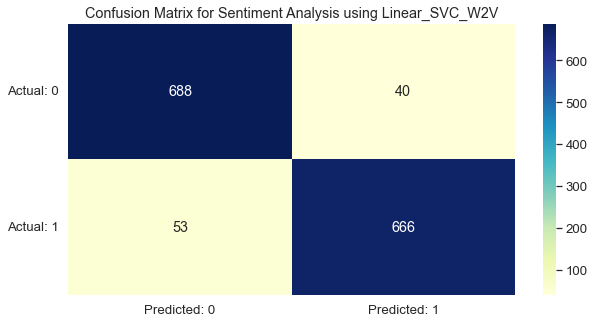

Confusion Matrix for Sentiment Analysis using Linear_SVC_W2V: 0.9357290946786455
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Linear_SVC_W2V:

               precision    recall  f1-score   support

           0       0.93      0.95      0.94       728
           1       0.94      0.93      0.93       719

    accuracy                           0.94      1447
   macro avg       0.94      0.94      0.94      1447
weighted avg       0.94      0.94      0.94      1447

----------------------------------------------------------------------------------------------------


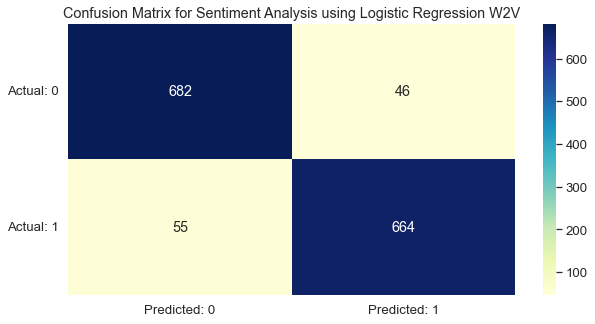

Confusion Matrix for Sentiment Analysis using Logistic Regression W2V: 0.9302004146510021
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Logistic Regression W2V:

               precision    recall  f1-score   support

           0       0.93      0.94      0.93       728
           1       0.94      0.92      0.93       719

    accuracy                           0.93      1447
   macro avg       0.93      0.93      0.93      1447
weighted avg       0.93      0.93      0.93      1447

----------------------------------------------------------------------------------------------------


In [52]:
plot_confusion_matrix(y_test,  naive_bayes_Word2Vec_prediction, "Naive Bayes W2V")
plot_confusion_matrix(y_test,  Linear_SVC_Word2Vec_prediction, "Linear_SVC_W2V")
plot_confusion_matrix(y_test,  Logistic_Regression_Word2Vec_prediction, "Logistic Regression W2V")

In [53]:
length = unseen_X_test_Word2Vec.shape[0]

start_time = time.time()
unseen_naive_bayes_Word2Vec_prediction = naive_bayes_Word2Vec.predict(unseen_X_test_Word2Vec)
time_taken = time.time()-start_time
classified_per_sec = length/time_taken
print("Predictions for Naive Bayes W2V took ", time_taken, " seconds")
print("Number of reviews classified for Naive Bayes W2V per second: ", classified_per_sec)
nb_w2v_time_list = ["Naive Bayes W2V",time_taken, classified_per_sec]

start_time = time.time()
unseen_Linear_SVC_Word2Vec_prediction = Linear_SVC_Word2Vec.predict(unseen_X_test_Word2Vec)
time_taken = time.time()-start_time
classified_per_sec = length/time_taken
print("Predictions for Linear_SVC W2V took ", time_taken, " seconds")
print("Number of reviews classified for Linear_SVC_W2V per second: ", classified_per_sec)
svc_w2v_time_list = ["Linear_SVC W2V",time_taken, classified_per_sec]

start_time=time.time()
unseen_Logistic_Regression_Word2Vec_prediction = Logistic_Regression_Word2Vec.predict(unseen_X_test_Word2Vec)
time_taken = time.time()-start_time
classified_per_sec = length/time_taken
print("Predictions for Linear_SVC W2V took ", time_taken, " seconds")
print("Number of reviews classified for Logistic_Regression_W2V per second: ", classified_per_sec)
lr_w2v_time_list = ["Logistic Regression W2V",time_taken, classified_per_sec]

Predictions for Naive Bayes W2V took  0.0020008087158203125  seconds
Number of reviews classified for Naive Bayes W2V per second:  1113049.9294566254
Predictions for Linear_SVC W2V took  0.0019178390502929688  seconds
Number of reviews classified for Linear_SVC_W2V per second:  1161202.7608155147
Predictions for Linear_SVC W2V took  0.0010104179382324219  seconds
Number of reviews classified for Logistic_Regression_W2V per second:  2204038.4634261443


## Saving Results

In [54]:
nb_w2v_test_df_predicted = get_pred_df(test_df, unseen_naive_bayes_Word2Vec_prediction)
nb_w2v_test_df_predicted.to_csv(path+'Naive_Bayes_W2V_results.csv')

svc_w2v_test_df_predicted = get_pred_df(test_df, unseen_Linear_SVC_Word2Vec_prediction)
svc_w2v_test_df_predicted.to_csv(path+'SVM_W2V_results.csv')

lr_w2v_test_df_predicted = get_pred_df(test_df, unseen_Logistic_Regression_Word2Vec_prediction)
lr_w2v_test_df_predicted.to_csv(path+'Logistic_Regression_W2V_results.csv')

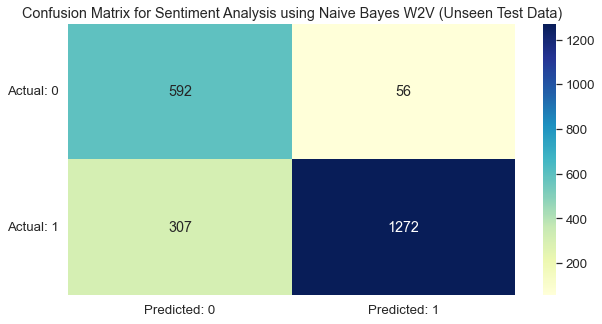

Confusion Matrix for Sentiment Analysis using Naive Bayes W2V (Unseen Test Data): 0.8370004490345757
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Naive Bayes W2V (Unseen Test Data):

               precision    recall  f1-score   support

           0       0.66      0.91      0.77       648
           1       0.96      0.81      0.88      1579

    accuracy                           0.84      2227
   macro avg       0.81      0.86      0.82      2227
weighted avg       0.87      0.84      0.84      2227

----------------------------------------------------------------------------------------------------


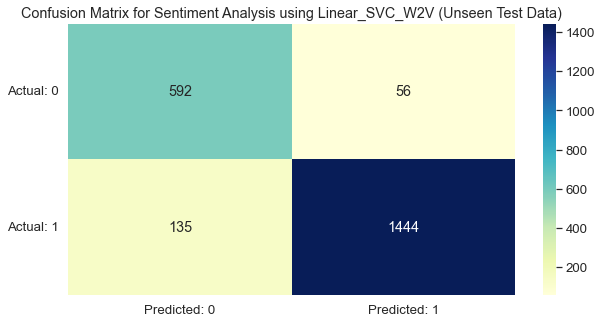

Confusion Matrix for Sentiment Analysis using Linear_SVC_W2V (Unseen Test Data): 0.9142343960484958
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Linear_SVC_W2V (Unseen Test Data):

               precision    recall  f1-score   support

           0       0.81      0.91      0.86       648
           1       0.96      0.91      0.94      1579

    accuracy                           0.91      2227
   macro avg       0.89      0.91      0.90      2227
weighted avg       0.92      0.91      0.92      2227

----------------------------------------------------------------------------------------------------


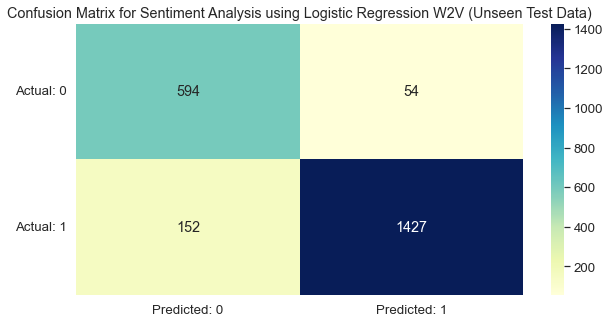

Confusion Matrix for Sentiment Analysis using Logistic Regression W2V (Unseen Test Data): 0.9074988774135608
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Logistic Regression W2V (Unseen Test Data):

               precision    recall  f1-score   support

           0       0.80      0.92      0.85       648
           1       0.96      0.90      0.93      1579

    accuracy                           0.91      2227
   macro avg       0.88      0.91      0.89      2227
weighted avg       0.91      0.91      0.91      2227

----------------------------------------------------------------------------------------------------


In [55]:
plot_confusion_matrix(unseen_Y_test,  unseen_naive_bayes_Word2Vec_prediction, "Naive Bayes W2V (Unseen Test Data)")
plot_confusion_matrix(unseen_Y_test,  unseen_Linear_SVC_Word2Vec_prediction, "Linear_SVC_W2V (Unseen Test Data)")
plot_confusion_matrix(unseen_Y_test,  unseen_Logistic_Regression_Word2Vec_prediction, "Logistic Regression W2V (Unseen Test Data)")

In [56]:
print("MultinomialNB Accuracy for Word2Vec:",metrics.accuracy_score(y_test, naive_bayes_Word2Vec_prediction))
print("MultinomialNB Accuracy for unseen test Word2Vec:",metrics.accuracy_score(unseen_Y_test, unseen_naive_bayes_Word2Vec_prediction))
naive_bayes_Word2Vec_score = metrics.accuracy_score(y_test, naive_bayes_Word2Vec_prediction)
unseen_naive_bayes_Word2Vec_score = metrics.accuracy_score(unseen_Y_test, unseen_naive_bayes_Word2Vec_prediction)

print("Linear SVC Accuracy for Linear_SVC_Word2Vec:",metrics.accuracy_score(y_test, Linear_SVC_Word2Vec_prediction))
print("Linear SVC Accuracy for unseen test Word2Vec:",metrics.accuracy_score(unseen_Y_test, unseen_Linear_SVC_Word2Vec_prediction))
Linear_SVC_Word2Vec_score = metrics.accuracy_score(y_test, Linear_SVC_Word2Vec_prediction)
unseen_Linear_SVC_Word2Vec_score = metrics.accuracy_score(unseen_Y_test, unseen_Linear_SVC_Word2Vec_prediction)

print("Logistic Regression Accuracy for Logistic_Regression_Word2Vec:",metrics.accuracy_score(y_test, Logistic_Regression_Word2Vec_prediction))
print("Logistic Regression Accuracy for unseen test Word2Vec:",metrics.accuracy_score(unseen_Y_test, unseen_Logistic_Regression_Word2Vec_prediction))
Logistic_Regression_Word2Vec_score = metrics.accuracy_score(y_test, Logistic_Regression_Word2Vec_prediction)
unseen_Logistic_Regression_Word2Vec_score = metrics.accuracy_score(unseen_Y_test, unseen_Logistic_Regression_Word2Vec_prediction)

W2V_score_list = [naive_bayes_Word2Vec_score, Linear_SVC_Word2Vec_score, Logistic_Regression_Word2Vec_score]
unseen_W2V_score_list = [unseen_naive_bayes_Word2Vec_score, unseen_Linear_SVC_Word2Vec_score, unseen_Logistic_Regression_Word2Vec_score]

MultinomialNB Accuracy for Word2Vec: 0.8804422944022114
MultinomialNB Accuracy for unseen test Word2Vec: 0.8370004490345757
Linear SVC Accuracy for Linear_SVC_Word2Vec: 0.9357290946786455
Linear SVC Accuracy for unseen test Word2Vec: 0.9142343960484958
Logistic Regression Accuracy for Logistic_Regression_Word2Vec: 0.9302004146510021
Logistic Regression Accuracy for unseen test Word2Vec: 0.9074988774135608


## Doc2Vec

In [57]:
naive_bayes_Doc2Vec = naive_bayes_model(X_train_Doc2Vec, Y_train)
# Support vector machine
Linear_SVC_Doc2Vec = Linear_SVC_model(X_train_Doc2Vec, Y_train)
Logistic_Regression_Doc2Vec= LogisticRegression_model(X_train_Doc2Vec, Y_train)

nb_d2v_file = "trained_models/Naive_Bayes_D2V_model.pkl"
linear_svc_d2v_file = "trained_models/Linear_SVC_D2V_model.pkl"
lr_d2v_file = "trained_models/Logistic_Regression_D2V_model.pkl"

joblib.dump(naive_bayes_Doc2Vec, nb_d2v_file)
joblib.dump(Linear_SVC_Doc2Vec, linear_svc_d2v_file)
joblib.dump(Logistic_Regression_Doc2Vec, lr_d2v_file)

['trained_models/Logistic_Regression_D2V_model.pkl']

In [58]:
naive_bayes_Doc2Vec_prediction = naive_bayes_Doc2Vec.predict(x_test_Doc2Vec)
Linear_SVC_Doc2Vec_prediction = Linear_SVC_Doc2Vec.predict(x_test_Doc2Vec)
Logistic_Regression_Doc2Vec_prediction = Logistic_Regression_Doc2Vec.predict(x_test_Doc2Vec)

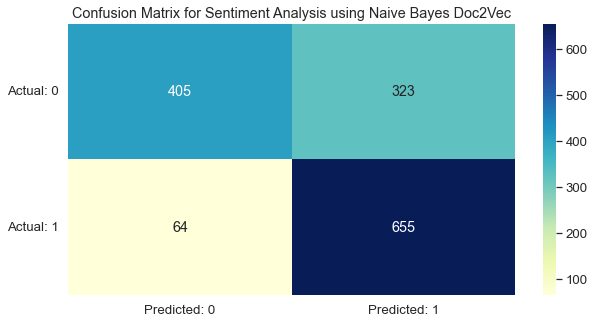

Confusion Matrix for Sentiment Analysis using Naive Bayes Doc2Vec: 0.7325501036627505
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Naive Bayes Doc2Vec:

               precision    recall  f1-score   support

           0       0.86      0.56      0.68       728
           1       0.67      0.91      0.77       719

    accuracy                           0.73      1447
   macro avg       0.77      0.73      0.72      1447
weighted avg       0.77      0.73      0.72      1447

----------------------------------------------------------------------------------------------------


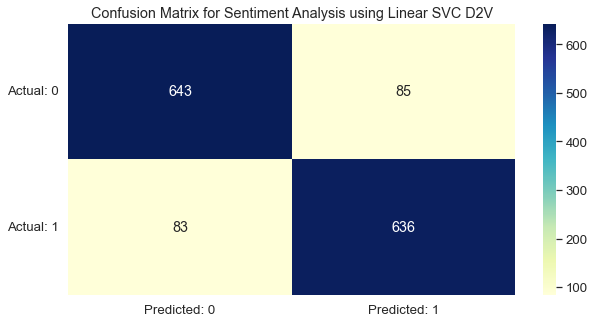

Confusion Matrix for Sentiment Analysis using Linear SVC D2V: 0.8838977194194886
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Linear SVC D2V:

               precision    recall  f1-score   support

           0       0.89      0.88      0.88       728
           1       0.88      0.88      0.88       719

    accuracy                           0.88      1447
   macro avg       0.88      0.88      0.88      1447
weighted avg       0.88      0.88      0.88      1447

----------------------------------------------------------------------------------------------------


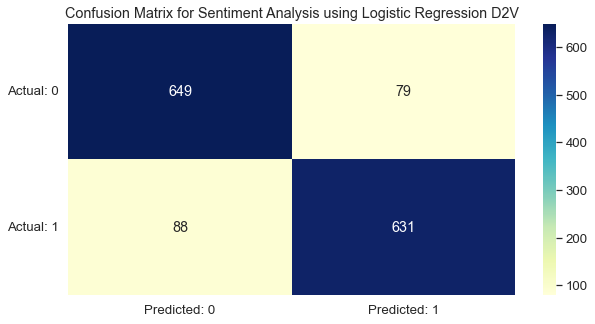

Confusion Matrix for Sentiment Analysis using Logistic Regression D2V: 0.8845888044229441
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Logistic Regression D2V:

               precision    recall  f1-score   support

           0       0.88      0.89      0.89       728
           1       0.89      0.88      0.88       719

    accuracy                           0.88      1447
   macro avg       0.88      0.88      0.88      1447
weighted avg       0.88      0.88      0.88      1447

----------------------------------------------------------------------------------------------------


In [59]:
plot_confusion_matrix(y_test,  naive_bayes_Doc2Vec_prediction, "Naive Bayes Doc2Vec")
plot_confusion_matrix(y_test, Linear_SVC_Doc2Vec_prediction, "Linear SVC D2V")
plot_confusion_matrix(y_test,  Logistic_Regression_Doc2Vec_prediction, "Logistic Regression D2V")


In [60]:
length = unseen_X_test_Doc2Vec.shape[0]

start_time = time.time()
unseen_naive_bayes_Doc2Vec_prediction = naive_bayes_Doc2Vec.predict(unseen_X_test_Doc2Vec)
time_taken = time.time()-start_time
classified_per_sec = length/time_taken
print("Predictions for Naive Bayes D2V took ", time_taken, " seconds")
print("Number of reviews classified for Naive Bayes D2V per second: ", classified_per_sec)
nb_d2v_time_list = ["Naive Bayes D2V",time_taken, classified_per_sec]

start_time= time.time()
unseen_Linear_SVC_Doc2Vec_prediction = Linear_SVC_Doc2Vec.predict(unseen_X_test_Doc2Vec)
time_taken = time.time()-start_time
classified_per_sec = length/time_taken
print("Predictions for Linear SVC D2V took ", time_taken, " seconds")
print("Number of reviews classified for Linear SVC D2V per second: ", classified_per_sec)
svc_d2v_time_list = ["Linear SVC D2V",time_taken, classified_per_sec]

start_time = time.time()
unseen_Logistic_Regression_Doc2Vec_prediction = Logistic_Regression_Doc2Vec.predict(unseen_X_test_Doc2Vec)
time_taken = time.time()-start_time
classified_per_sec = length/time_taken
print("Predictions for Linear SVC D2V took ", time_taken, " seconds")
print("Number of reviews classified for Linear SVC D2V per second: ", classified_per_sec)
lr_d2v_time_list = ["Logistic Regression D2V",time_taken, classified_per_sec]

Predictions for Naive Bayes D2V took  0.0012331008911132812  seconds
Number of reviews classified for Naive Bayes D2V per second:  1806016.049497293
Predictions for Linear SVC D2V took  0.0005707740783691406  seconds
Number of reviews classified for Linear SVC D2V per second:  3901718.8838763577
Predictions for Linear SVC D2V took  0.0015153884887695312  seconds
Number of reviews classified for Linear SVC D2V per second:  1469590.152297042


## Saving Results

In [61]:
nb_d2v_test_df_predicted = get_pred_df(test_df, unseen_naive_bayes_Word2Vec_prediction)
nb_d2v_test_df_predicted.to_csv(path+'Naive_Bayes_D2V_results.csv')

svc_d2v_test_df_predicted = get_pred_df(test_df, unseen_Linear_SVC_Doc2Vec_prediction)
svc_d2v_test_df_predicted.to_csv(path+'SVM_D2V_results.csv')

lr_d2v_test_df_predicted = get_pred_df(test_df, unseen_Logistic_Regression_Doc2Vec_prediction)
lr_d2v_test_df_predicted.to_csv(path+'Logistic_Regression_D2V_results.csv')

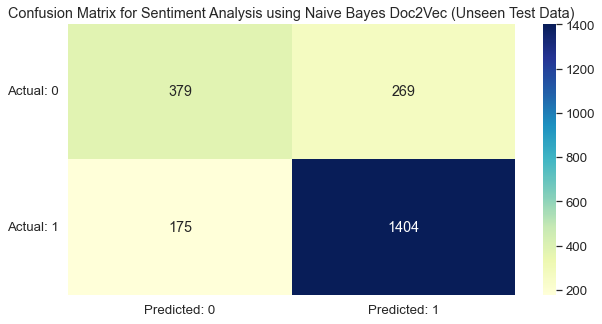

Confusion Matrix for Sentiment Analysis using Naive Bayes Doc2Vec (Unseen Test Data): 0.8006286484059273
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Naive Bayes Doc2Vec (Unseen Test Data):

               precision    recall  f1-score   support

           0       0.68      0.58      0.63       648
           1       0.84      0.89      0.86      1579

    accuracy                           0.80      2227
   macro avg       0.76      0.74      0.75      2227
weighted avg       0.79      0.80      0.80      2227

----------------------------------------------------------------------------------------------------


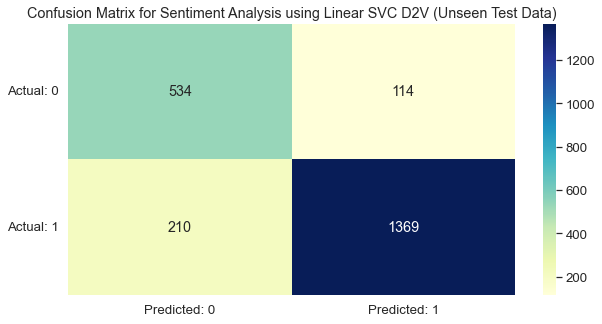

Confusion Matrix for Sentiment Analysis using Linear SVC D2V (Unseen Test Data): 0.8545127974854064
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Linear SVC D2V (Unseen Test Data):

               precision    recall  f1-score   support

           0       0.72      0.82      0.77       648
           1       0.92      0.87      0.89      1579

    accuracy                           0.85      2227
   macro avg       0.82      0.85      0.83      2227
weighted avg       0.86      0.85      0.86      2227

----------------------------------------------------------------------------------------------------


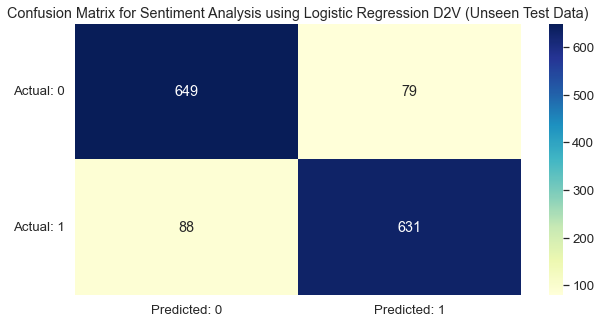

Confusion Matrix for Sentiment Analysis using Logistic Regression D2V (Unseen Test Data): 0.8845888044229441
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Logistic Regression D2V (Unseen Test Data):

               precision    recall  f1-score   support

           0       0.88      0.89      0.89       728
           1       0.89      0.88      0.88       719

    accuracy                           0.88      1447
   macro avg       0.88      0.88      0.88      1447
weighted avg       0.88      0.88      0.88      1447

----------------------------------------------------------------------------------------------------


In [62]:
plot_confusion_matrix(unseen_Y_test,  unseen_naive_bayes_Doc2Vec_prediction, "Naive Bayes Doc2Vec (Unseen Test Data)")
plot_confusion_matrix(unseen_Y_test, unseen_Linear_SVC_Doc2Vec_prediction, "Linear SVC D2V (Unseen Test Data)")
plot_confusion_matrix(y_test,  Logistic_Regression_Doc2Vec_prediction, "Logistic Regression D2V (Unseen Test Data)")

In [63]:
print("MultinomialNB Accuracy for Doc2Vec:",metrics.accuracy_score(y_test, naive_bayes_Doc2Vec_prediction))
print("MultinomialNB Accuracy for unseen test Doc2Vec:",metrics.accuracy_score(unseen_Y_test, unseen_naive_bayes_Doc2Vec_prediction))
naive_bayes_Doc2Vec_score = metrics.accuracy_score(y_test, naive_bayes_Doc2Vec_prediction)
unseen_naive_bayes_Doc2Vec_score = metrics.accuracy_score(unseen_Y_test, unseen_naive_bayes_Doc2Vec_prediction)

print("Linear_SVC Accuracy for Doc2Vec:",metrics.accuracy_score(y_test, Linear_SVC_Doc2Vec_prediction))
print("Linear_SVC Accuracy for unseen test Doc2Vec:",metrics.accuracy_score(unseen_Y_test, unseen_Linear_SVC_Doc2Vec_prediction))
Linear_SVC_Doc2Vec_score = metrics.accuracy_score(y_test, Linear_SVC_Doc2Vec_prediction)
unseen_Linear_SVC_Doc2Vec_score = metrics.accuracy_score(unseen_Y_test, unseen_Linear_SVC_Doc2Vec_prediction)

print("Logistic Regression Accuracy for Doc2Vec:",metrics.accuracy_score(y_test, Logistic_Regression_Doc2Vec_prediction))
print("Logistic Regression Accuracy for unseen Doc2Vec:",metrics.accuracy_score(unseen_Y_test, unseen_Logistic_Regression_Doc2Vec_prediction))
Logistic_Regression_Doc2Vec_score = metrics.accuracy_score(y_test, Logistic_Regression_Doc2Vec_prediction)
unseen_Logistic_Regression_Doc2Vec_score = metrics.accuracy_score(unseen_Y_test, unseen_Logistic_Regression_Doc2Vec_prediction)

D2V_score_list = [naive_bayes_Doc2Vec_score, Linear_SVC_Doc2Vec_score, Logistic_Regression_Doc2Vec_score]
unseen_D2V_score_list = [unseen_naive_bayes_Doc2Vec_score, unseen_Linear_SVC_Doc2Vec_score, unseen_Logistic_Regression_Doc2Vec_score]

MultinomialNB Accuracy for Doc2Vec: 0.7325501036627505
MultinomialNB Accuracy for unseen test Doc2Vec: 0.8006286484059273
Linear_SVC Accuracy for Doc2Vec: 0.8838977194194886
Linear_SVC Accuracy for unseen test Doc2Vec: 0.8545127974854064
Logistic Regression Accuracy for Doc2Vec: 0.8845888044229441
Logistic Regression Accuracy for unseen Doc2Vec: 0.8563089357880557


## Model Comparison

In [64]:
time_taken_data = [nb_tfidf_time_list,svc_tfidf_time_list,lr_tfidf_time_list,
                    nb_w2v_time_list,svc_w2v_time_list,lr_w2v_time_list,
                    nb_d2v_time_list,svc_d2v_time_list,lr_d2v_time_list]

time_taken_data = pd.DataFrame(time_taken_data, columns = ["Model Name", "Time Taken for Prediction(Seconds)", "# Reviews Per Second"])
time_taken_data.head(30)

,Model Name,Time Taken for Prediction(Seconds),# Reviews Per Second
0,Naive Bayes TFIF,0.002000,1.113713e+06
1,Linear_SVC TF-IDF,0.001007,2.211867e+06
2,Logistic Regression TF-IDF,0.001185,1.879041e+06
3,Naive Bayes W2V,0.002001,1.113050e+06
4,Linear_SVC W2V,0.001918,1.161203e+06
5,Logistic Regression W2V,0.001010,2.204038e+06
6,Naive Bayes D2V,0.001233,1.806016e+06
7,Linear SVC D2V,0.000571,3.901719e+06
8,Logistic Regression D2V,0.001515,1.469590e+06


In [65]:
naive_bayes_model = [naive_bayes_tfidf_score, naive_bayes_Word2Vec_score, naive_bayes_Doc2Vec_score]
linear_svc_model = [Linear_SVC_tfidf_score, Linear_SVC_Word2Vec_score, Linear_SVC_Doc2Vec_score]
logistic_regression_model = [Logistic_Regression_tfidf_score, Logistic_Regression_Word2Vec_score, Logistic_Regression_Doc2Vec_score]


unseen_naive_bayes_model = [unseen_naive_bayes_tfidf_score, unseen_naive_bayes_Word2Vec_score, unseen_naive_bayes_Doc2Vec_score]
unseen_linear_svc_model = [unseen_Linear_SVC_tfidf_score, unseen_Linear_SVC_Word2Vec_score, unseen_Linear_SVC_Doc2Vec_score]
unseen_logistic_regression_model = [unseen_Logistic_Regression_tfidf_score, unseen_Logistic_Regression_Word2Vec_score, unseen_Logistic_Regression_Doc2Vec_score]

In [66]:
def comparing_models(naive_bayes, linear_svc, logistic_regression):
    fig, axes =plt.subplots(1,3, figsize=(20,20))
    # Bag of Words classifiers
    classifiers = ["TFIDF", "Word2Vec", "Doc2Vec"]

    color_discrete_map=['red', 'yellow', 'blue']
    accuracy = naive_bayes
    axes[0].set_title("Naive Bayes")
    axes[0].set_xlabel('Text Representation')
    axes[0].set_ylabel('Accuracy')
    axes[0].bar(classifiers, accuracy, color = color_discrete_map, width=0.5)


    accuracy =  linear_svc
    axes[1].set_title('Linear SVC')
    axes[1].set_xlabel('Text Representation')
    axes[1].set_ylabel('Accuracy')
    axes[1].bar(classifiers, accuracy, color = color_discrete_map, width=0.5)


    accuracy = logistic_regression
    axes[2].set_title('Logistic Regression')
    axes[2].set_xlabel('Text Representation')
    axes[2].set_ylabel(' Unseen Test Accuracy')
    axes[2].bar(classifiers, accuracy, color = color_discrete_map, width=0.5)
    plt.show()


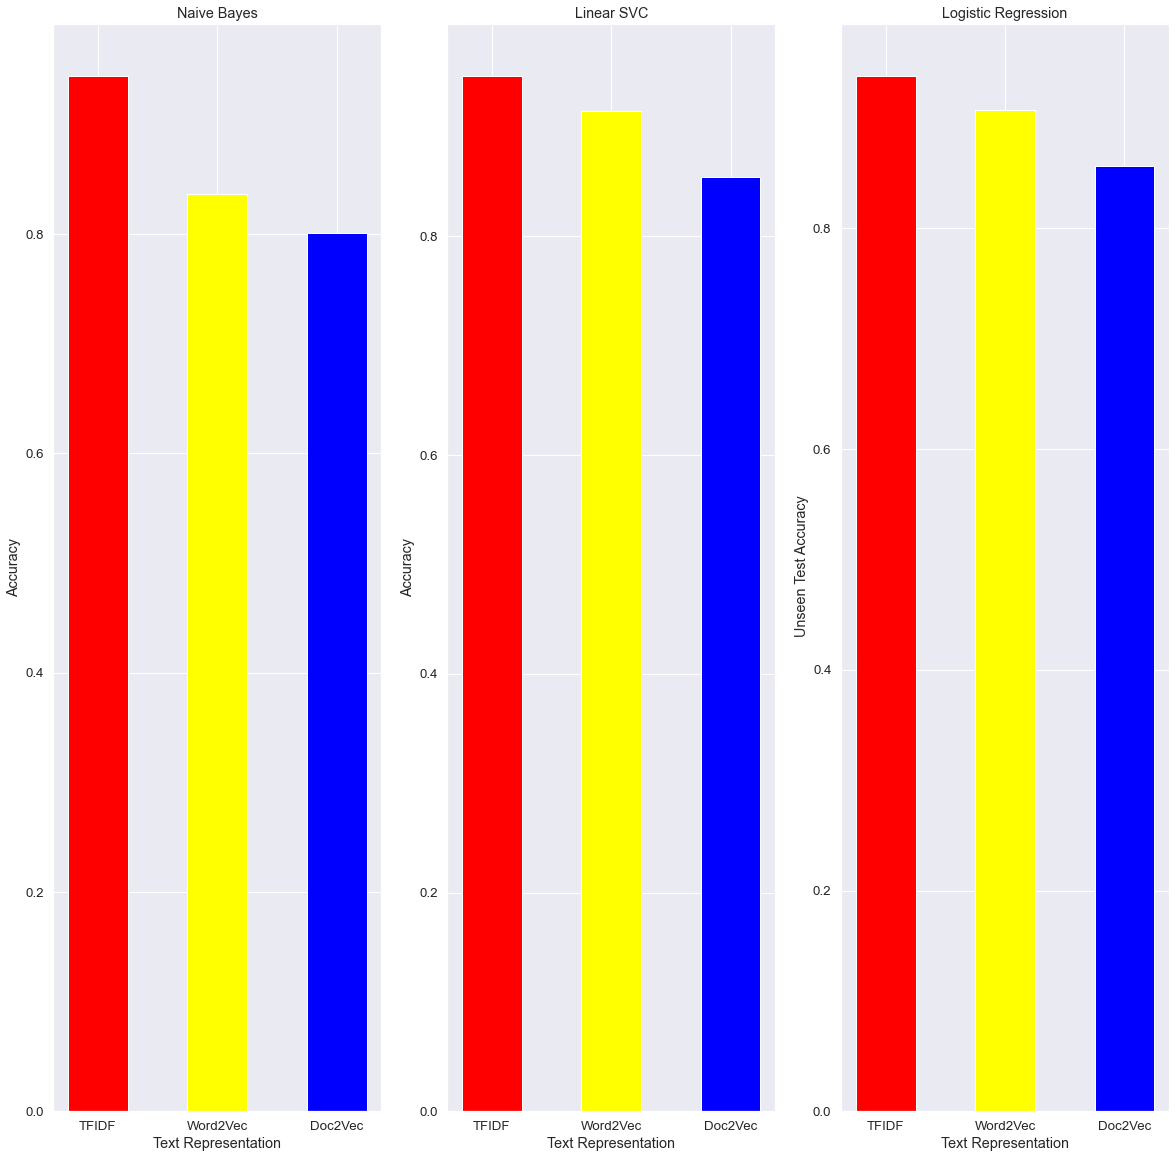

In [67]:
comparing_models(unseen_naive_bayes_model, unseen_linear_svc_model, unseen_logistic_regression_model)

# Ensemble Learning FOR TF-IDF (Voting Classifier)

In [68]:
from sklearn.ensemble import VotingClassifier
# As the TF-IDF models are the best performing, lets see if we can improve using voting classifier
estimators=[("Naive Bayes TFIDF", naive_bayes_tfidf), ("Linear SVC TFIDF", Linear_SVC_tfidf), ("Logistic Regression TFIDF", Logistic_Regression_tfidf)]
#create our voting classifier, inputting our models
tf_idf_ensemble = VotingClassifier(estimators, voting="hard")

In [69]:
tf_idf_ensemble.fit(X_train_tfidf, Y_train)
tf_idf_ensemble_file = 'trained_models/voting_tf_idf_ensemble.pkl'
joblib.dump(tf_idf_ensemble, tf_idf_ensemble_file)

['trained_models/voting_tf_idf_ensemble.pkl']

In [70]:
# TF-IDF prediction on unseen Test Set
tf_idf_pred = tf_idf_ensemble.predict(unseen_X_test_tfidf)


In [71]:
print("Ensemble Model TF-IDF accuracy:",metrics.accuracy_score(unseen_Y_test, tf_idf_pred))
Ensemble_model_tfidf_score = metrics.accuracy_score(unseen_Y_test, tf_idf_pred)

Ensemble Model TF-IDF accuracy: 0.9488100583744948


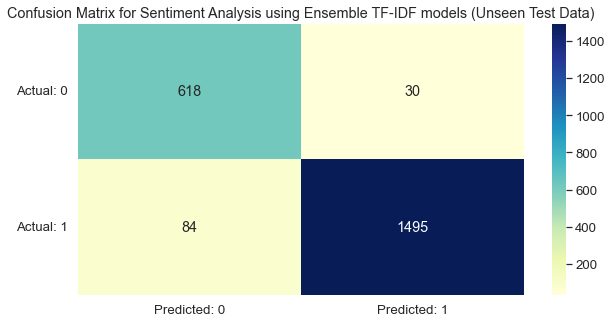

Confusion Matrix for Sentiment Analysis using Ensemble TF-IDF models (Unseen Test Data): 0.9488100583744948
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Ensemble TF-IDF models (Unseen Test Data):

               precision    recall  f1-score   support

           0       0.88      0.95      0.92       648
           1       0.98      0.95      0.96      1579

    accuracy                           0.95      2227
   macro avg       0.93      0.95      0.94      2227
weighted avg       0.95      0.95      0.95      2227

----------------------------------------------------------------------------------------------------


In [72]:
plot_confusion_matrix(unseen_Y_test,  tf_idf_pred , "Ensemble TF-IDF models (Unseen Test Data)")

In [73]:
voting_classifier_test_df_predicted = get_pred_df(test_df, tf_idf_pred)
voting_classifier_test_df_predicted.to_csv(path+'voting_classifier_results.csv')

# Ensemble Stacking for TF-IDF (StackingClassifier)

In [74]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import StackingClassifier

In [75]:
clf = [('Logistic Regression',Logistic_Regression_tfidf),('Naive Bayes',naive_bayes_tfidf)]
stack_model = StackingClassifier(estimators = clf, final_estimator=Linear_SVC_tfidf)


In [76]:
stack_model.fit(X_train_tfidf, Y_train)
tf_idf_stack_ensemble_file = 'trained_models/tf_idf_stack_ensemble.pkl'
joblib.dump(tf_idf_ensemble, tf_idf_stack_ensemble_file)

['trained_models/tf_idf_stack_ensemble.pkl']

In [77]:
# TF-IDF prediction on unseen Test Set
stacked_tf_idf_pred = stack_model.predict(unseen_X_test_tfidf)

In [78]:
print("Stacked model TF-IDF accuracy:",metrics.accuracy_score(unseen_Y_test, stacked_tf_idf_pred))
Stacked_model_tfidf_score = metrics.accuracy_score(unseen_Y_test, stacked_tf_idf_pred)

Stacked model TF-IDF accuracy: 0.9452177817691962


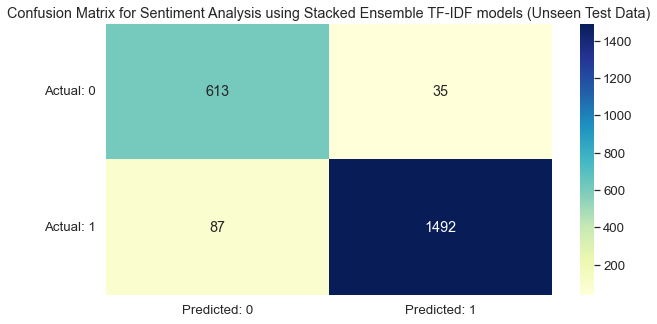

Confusion Matrix for Sentiment Analysis using Stacked Ensemble TF-IDF models (Unseen Test Data): 0.9452177817691962
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using Stacked Ensemble TF-IDF models (Unseen Test Data):

               precision    recall  f1-score   support

           0       0.88      0.95      0.91       648
           1       0.98      0.94      0.96      1579

    accuracy                           0.95      2227
   macro avg       0.93      0.95      0.94      2227
weighted avg       0.95      0.95      0.95      2227

----------------------------------------------------------------------------------------------------


In [79]:
plot_confusion_matrix(unseen_Y_test,  stacked_tf_idf_pred , "Stacked Ensemble TF-IDF models (Unseen Test Data)")

In [80]:
stacked_classifier_test_df_predicted = get_pred_df(test_df,stacked_tf_idf_pred)
stacked_classifier_test_df_predicted.to_csv(path+'stacked_classifier_results.csv')